In [22]:
%load_ext autoreload
%autoreload 2

from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import shap
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from biobank_olink.constants import PROJECT_DATA

nb_data = PROJECT_DATA / "olink"
olink_parquet = nb_data / "Olink_whole_caucasian_nonrandom_Zscore.parquet"

TEST_SIZE = 0.2
MAX_SHAP_FEATS = 15

sns.set_theme()
pl.__version__

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'1.9.0'

In [23]:
import polars.selectors as cs

feat2code = {
    "SBP": "4080",
    "DBP": "4079",
    "ASI": "21021",
    "DATE": "53",
    "DRUGS_Q1": "6177",
    "DRUGS_Q2": "6153",

}
instances = [0, 1, 2, 3]

df_followups = (
    pl.scan_csv(nb_data / "BP_ASI_instances0123_participant.csv").join(
        pl.scan_csv(nb_data / "Drugs_instances123_participant.csv", infer_schema_length=1_000_000),
        on="eid"
    )
    .select(
        "eid",
        *[
            pl.concat_list(cs.contains(f"{feat2code[feat]}-{ins}.")).list.mean().alias(
                f"{feat}/{ins}")
            for feat in ["SBP", "DBP"]
            for ins in instances
        ],
        *[
            pl.col(f"{feat2code[feat]}-{ins}.0").cast(t).alias(f"{feat}/{ins}")
            for feat, t in [("ASI", pl.Float64), ("DATE", pl.Date)]
            for ins in instances
        ],
        *[
            pl.any_horizontal(
                pl.col(f"{feat2code[feat]}-{ins}.0").str.contains("2")
                for feat in ["DRUGS_Q1", "DRUGS_Q2"]
            ).fill_null(False).alias(f"BP_DRUGS/{ins}")
            for ins in instances[1:]
        ],
    )
    .with_columns(
        (pl.col("^DATE/[123]$") - pl.col("DATE/0")).dt.total_days() / 365.25
    )
    .drop("DATE/0")
    .unpivot(index="eid")
    .filter(pl.col("value").is_not_null())
    .with_columns(
        pl.col("variable").str.split_exact("/", 1)
    )
    .with_columns(
        variable=pl.col("variable").struct[0],
        ins_index=pl.col("variable").struct[1].cast(pl.Int64)
    )
    .collect()
    .pivot(index=["eid", "ins_index"], on="variable")
    .rename({"DATE": "followup_time"})
    # Remove rows where a patient does take BP drugs,
    # so BP_DRUGS is null or 0 (false)
    .filter(pl.col("BP_DRUGS").is_null() | (pl.col("BP_DRUGS") == 0))
    .drop("BP_DRUGS")
)

In [24]:
def create_target_at_followups(target) -> pl.DataFrame:
    df_baseline = (
        df_followups
        .filter(pl.col("ins_index") == 0, pl.col(target).is_not_null())
        .rename({target: "target_at_baseline"})
        .select("eid", "target_at_baseline")
    )
    return (
        df_followups
        .filter(
            pl.col("ins_index") != 0,
            pl.col(target).is_not_null(),
        )
        .select("eid", target, "followup_time")
        .join(df_baseline, on="eid")
        .select(
            "eid",
            "followup_time",
            target=(pl.col(target) - pl.col("target_at_baseline")) / pl.col("followup_time")
        )
    )


In [25]:
index_cols = ["eid", "sex", "age", "BMI", "Smokinstatus"]
cols = ["protein_id", "result"] + index_cols

coding = (
    pl.read_csv(nb_data / "coding143.tsv", separator="\t")
    .with_columns(pl.col("meaning").str.split(";").list.get(0))
)


def create_dataset(target) -> pl.DataFrame:
    df_target = create_target_at_followups(target)
    df_ol = (
        pl.scan_parquet(olink_parquet.with_suffix(".parquet"))
        .filter(
            pl.col("HTNgroup").is_in([0, 1]),
            pl.col("eid").is_in(df_target["eid"]),
        )
        .select(cols)
        .with_columns(
            pl.col("protein_id").replace_strict(
                coding["coding"], coding["meaning"], return_dtype=pl.String
            )
        )
        .collect()
        .pivot(on="protein_id", index=index_cols, values="result",
               aggregate_function="first")
    )
    df_ol = (
        df_ol.with_columns(
            df_ol["Smokinstatus"].to_dummies(drop_first=True)
        )
        .drop("Smokinstatus")
    )
    return df_ol.join(df_target, on="eid", how="inner").drop("eid")

In [26]:
import wandb


def shap_to_importance(values, feat_names) -> pd.Series:
    return (
        pd.Series(np.abs(values.values).sum(axis=0), index=feat_names)
        .sort_values(ascending=False)
    )


def print_true_vs_pred(y_true, y_pred, title="Train"):
    ax = sns.scatterplot(x=y_true, y=y_pred, alpha=0.4)
    max_lim = max(ax.get_xlim()[1], ax.get_ylim()[1])
    min_lim = min(ax.get_xlim()[0], ax.get_ylim()[0])
    ax.set(xlabel="y_true", ylabel="y_pred", title=title,
           xlim=(min_lim, max_lim), ylim=(min_lim, max_lim))


def setup_xgb(config, seed=42, device="gpu", is_regression: bool = True) -> xgb.XGBRegressor:
    xgb_params = dict(config)

    early_stop = xgb.callback.EarlyStopping(
        rounds=10, save_best=True
    )

    model = xgb.XGBRegressor if is_regression else xgb.XGBClassifier
    return model(
        tree_method="hist",
        device=device,
        random_state=seed,
        callbacks=[early_stop],
        **xgb_params,
    )


def eval_xgb(x, y, config, seed=42, device="gpu", is_regression: bool = True) -> xgb.XGBRegressor:
    if not is_regression:
        y = y > 0
        print(f"Prevalence={y.mean():.2%}")
        
    x_train, x_eval, y_train, y_eval = train_test_split(x, y, test_size=TEST_SIZE,
                                                        random_state=seed)

    clf = setup_xgb(config, seed, device, is_regression)
    clf.fit(x_train, y_train, eval_set=[(x_eval, y_eval)], verbose=10)

    y_train_pred = clf.predict(x_train)
    if is_regression:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        corr_train = np.corrcoef(y_train, y_train_pred)[1, 0]
        print_true_vs_pred(y_train, y_train_pred,
                           title=f"Train (r2={clf.score(x_train, y_train):.4f}, corr={corr_train:.4f})")
    else:
        f1 = f1_score(y_train, y_train_pred)
        print(f"Train (acc={clf.score(x_train, y_train):.4f}, f1={f1:.4f})")
        
    y_eval_pred = clf.predict(x_eval)
    if is_regression:
        plt.subplot(1, 2, 2)
        corr_eval = np.corrcoef(y_eval, y_eval_pred)[1, 0]
        print_true_vs_pred(y_eval, y_eval_pred,
                           title=f"Eval (r2={clf.score(x_eval, y_eval):.4f}, corr={corr_eval:.4f})")
    else:
        f1 = f1_score(y_eval, y_eval_pred)
        print(f"Eval (acc={clf.score(x_eval, y_eval):.4f}, f1={f1:.4f})")
               
    return clf


def get_elbow_point(series: pd.Series) -> int:
    from kneed import KneeLocator

    x = np.arange(0, len(series))
    y = series.values
    kneedle = KneeLocator(x, y, curve='convex', direction='decreasing')
    elbow_point = kneedle.elbow

    ax = series.plot.line()
    ax.axvline(x=elbow_point, color='k', linestyle='--', lw=1)
    return elbow_point


def get_xy(target) -> tuple[pl.DataFrame, pl.Series]:
    df = create_dataset(target)
    x, y = df.drop("target"), df["target"]
    print("X shape:", x.shape)
    return x, y

## SDB

wandb: Sorting runs by -summary_metrics.r2


X shape: (3733, 2930)
[0]	validation_0-rmse:1.68358
[10]	validation_0-rmse:1.66746
[20]	validation_0-rmse:1.65793
[30]	validation_0-rmse:1.65245
[40]	validation_0-rmse:1.65022
[49]	validation_0-rmse:1.64954


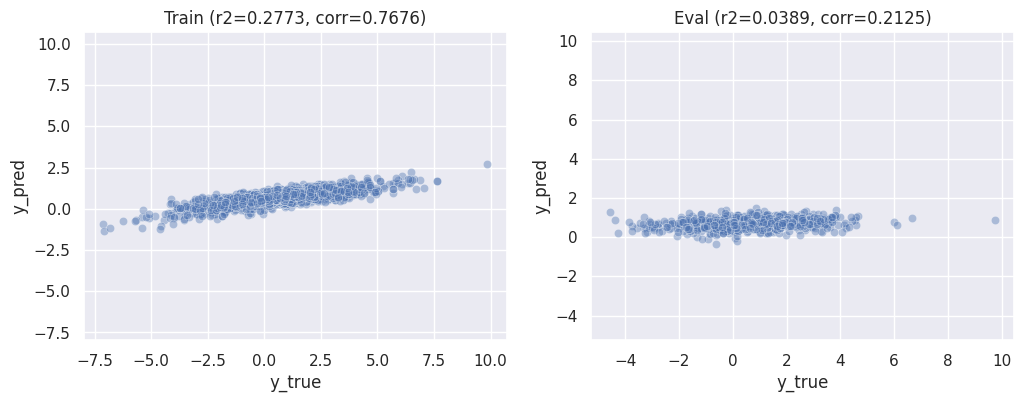

In [27]:
x_sbp, y_sbp = get_xy("SBP")
best_run  = wandb.Api().sweep("olink_change_sbp/4hemj7zq").best_run(order="r2")
model_sbp = eval_xgb(x_sbp, y_sbp, best_run.config)

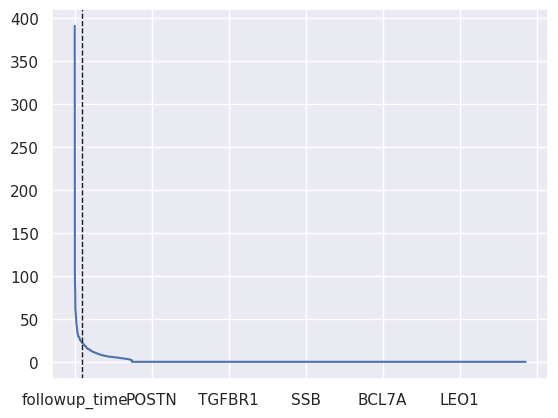

In [28]:
explainer = shap.TreeExplainer(model_sbp)
shap_values_sbp = explainer(x_sbp)
imps = shap_to_importance(shap_values_sbp, x_sbp.columns)
sbp_elbow = get_elbow_point(imps)
sbp_important_feats = imps[:sbp_elbow]

In [29]:
sbp_important_feats.index.values, f"Number of important feats: {len(sbp_important_feats)}"

(array(['followup_time', 'MMP10', 'age', 'KIR3DL1', 'TMPRSS15', 'IL1RN',
        'PDE1C', 'MATN2', 'MUC2', 'LHB', 'FLRT2', 'CXCL14', 'CA4', 'TDRKH',
        'LRRC38', 'CD46', 'FSHB', 'CTSS', 'CST6', 'MUC16', 'SAG',
        'SMPDL3A', 'SERPINE2', 'PSPN', 'CDCP1', 'NELL1', 'VAMP5', 'ANG',
        'LMOD2', 'HAVCR2', 'PCDH12', 'FOLR3', 'KIF20B', 'DPP7', 'IGF2R',
        'IFNL1', 'VSIG4', 'NFATC3', 'CDC37', 'IL20RA', 'MATN3',
        'SERPINA11', 'ACP5', 'PTH1R', 'CDC123', 'VEGFB', 'LECT2', 'ANXA5',
        'FAM3C'], dtype=object),
 'Number of important feats: 49')

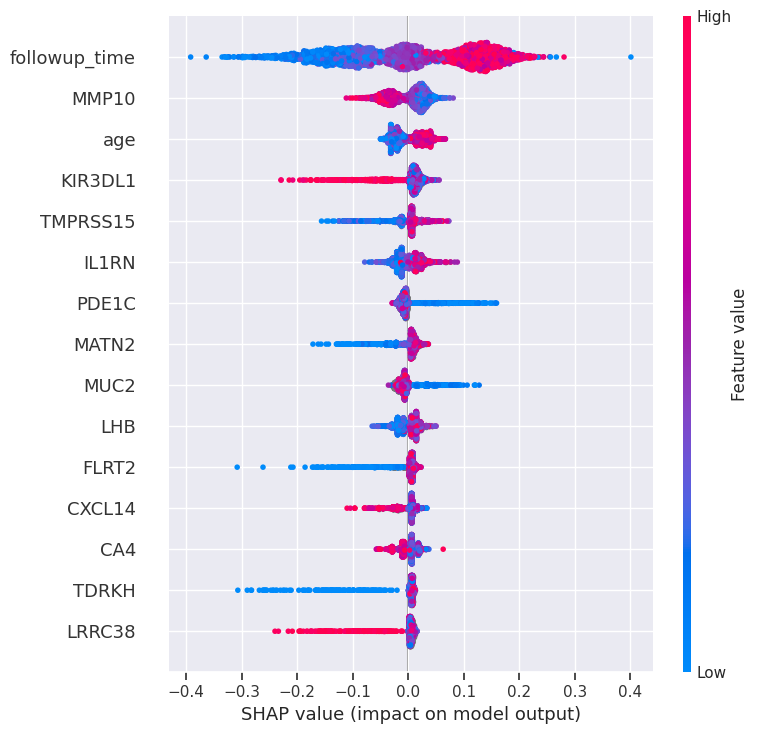

In [30]:
shap.summary_plot(shap_values_sbp, x_sbp.to_pandas(),
                  max_display=min(len(sbp_important_feats), MAX_SHAP_FEATS))

In [32]:
x_asi, y_asi = get_xy("SBP")
best_run = wandb.Api().sweep("olink_change_sbp_clf/pzw9gwpc").best_run(order="acc")
model_asi = eval_xgb(x_asi, y_asi, best_run.config, is_regression=False)

wandb: Sorting runs by -summary_metrics.acc


X shape: (3733, 2930)
Prevalence=67.93%
[0]	validation_0-logloss:0.63406
[10]	validation_0-logloss:0.62445
[20]	validation_0-logloss:0.62530
[26]	validation_0-logloss:0.63347
Train (acc=0.9377, f1=0.9563)
Eval (acc=0.6707, f1=0.7953)


## DBP

wandb: Sorting runs by -summary_metrics.r2


X shape: (3733, 2930)
[0]	validation_0-rmse:0.99621
[10]	validation_0-rmse:0.99148
[20]	validation_0-rmse:0.99136
[30]	validation_0-rmse:0.98564
[40]	validation_0-rmse:0.98171
[50]	validation_0-rmse:0.97915
[60]	validation_0-rmse:0.97821
[69]	validation_0-rmse:0.98092


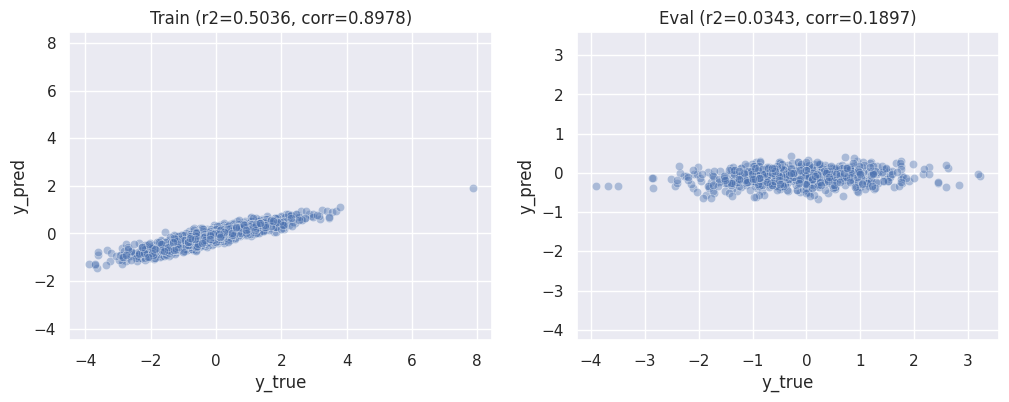

In [33]:
x_dbp, y_dbp = get_xy("DBP")
best_run = wandb.Api().sweep("olink_change_dbp/1gnmkxky").best_run(order="r2")
model_dbp = eval_xgb(x_dbp, y_dbp, best_run.config)

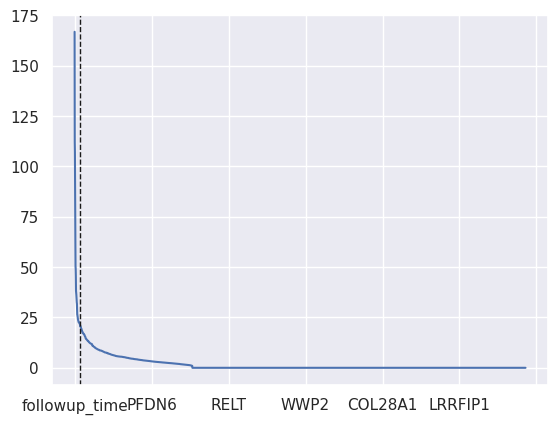

In [34]:
explainer = shap.TreeExplainer(model_dbp)
shap_values_dbp = explainer(x_dbp)
imps = shap_to_importance(shap_values_dbp, x_dbp.columns)
dbp_elbow = get_elbow_point(imps)
dbp_important_feats = imps[:dbp_elbow]

In [35]:
dbp_important_feats.index.values, f"Number of important feats: {len(dbp_important_feats)}"

(array(['followup_time', 'age', 'MATN2', 'GIP', 'SCLY', 'MAMDC4', 'AGER',
        'GCG', 'SAG', 'FABP9', 'MOG', 'KLK6', 'AGRP', 'COL18A1', 'GSTA3',
        'CEACAM5', 'LTBP2', 'CCL28', 'IL20', 'KRT8', 'CHIT1', 'RBP5',
        'GAGE2A', 'PKD1', 'FUCA1', 'CRHR1', 'ACY1', 'ULBP2', 'CRH',
        'GDF15', 'C2', 'FTCD', 'LDLR', 'SELE', 'PIK3AP1', 'IL17D'],
       dtype=object),
 'Number of important feats: 36')

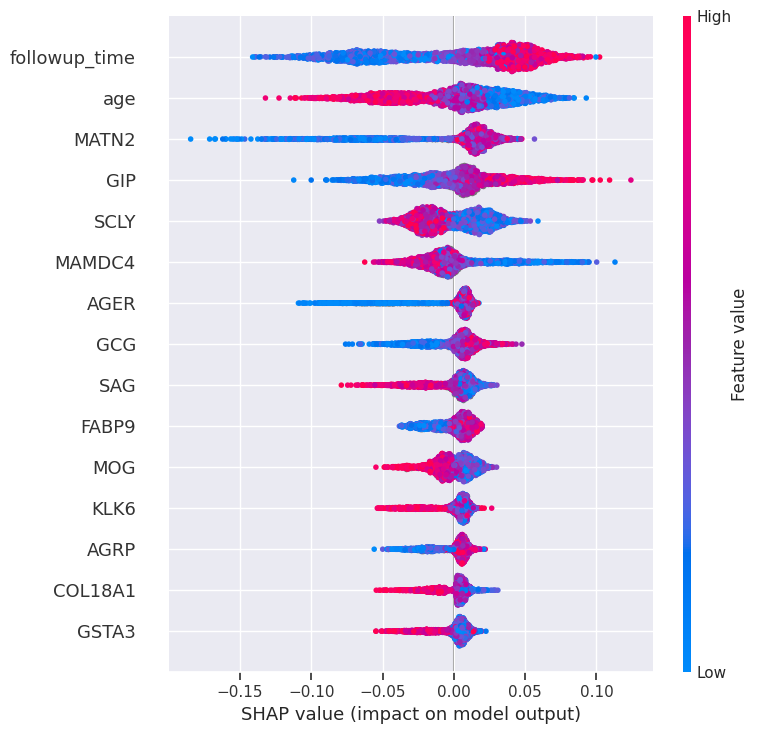

In [36]:
shap.summary_plot(shap_values_dbp, x_dbp.to_pandas(),
                  max_display=min(len(dbp_important_feats), MAX_SHAP_FEATS))

## ASI

wandb: Sorting runs by -summary_metrics.r2


X shape: (1868, 2930)
[0]	validation_0-rmse:0.78397
[10]	validation_0-rmse:0.75757
[20]	validation_0-rmse:0.74928
[30]	validation_0-rmse:0.74435
[34]	validation_0-rmse:0.74695


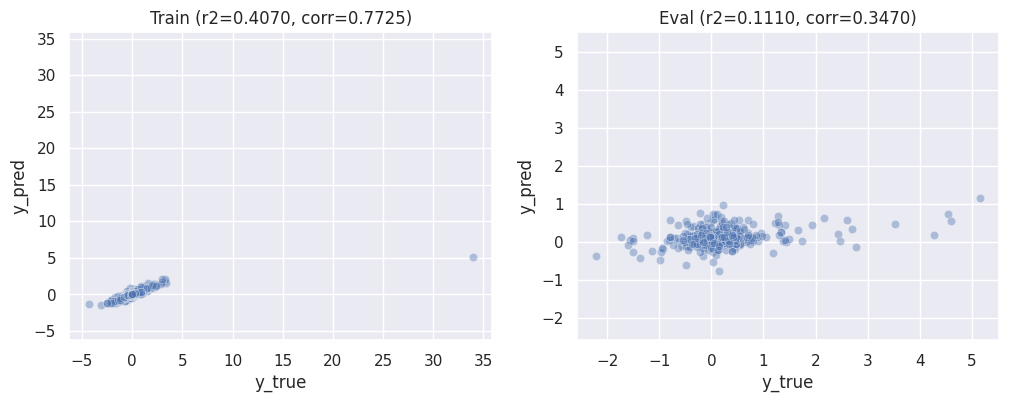

In [37]:
x_asi, y_asi = get_xy("ASI")
best_run = wandb.Api().sweep("olink_change_asi/a3tve1cv").best_run(order="r2")
model_asi = eval_xgb(x_asi, y_asi, best_run.config)

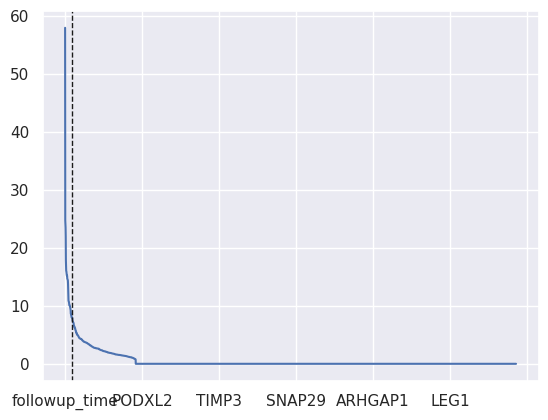

In [38]:
explainer = shap.TreeExplainer(model_asi)
shap_values_asi = explainer(x_asi)
imps = shap_to_importance(shap_values_asi, x_asi.columns)
asi_elbow = get_elbow_point(imps)
asi_important_feats = imps[:asi_elbow]

In [39]:
asi_important_feats.index.values, f"Number of important feats: {len(asi_important_feats)}"

(array(['followup_time', 'IL19', 'TXNDC15', 'age', 'COQ7', 'LBP', 'CRHR1',
        'CLEC4M', 'EPPK1', 'ENTPD6', 'PDZK1', 'MYBPC2', 'PECR', 'ZCCHC8',
        'FLT1', 'NUDT10', 'ABRAXAS2', 'FCGR3B', 'BTC', 'CD209', 'LGALS4',
        'CNPY2', 'ENTPD2', 'SCRN1', 'PADI4', 'FCAR', 'CCL8', 'PLA2G7',
        'TGFBI', 'SERPINA5', 'GRIN2B', 'CTSH', 'GFAP', 'SOD1', 'SPARCL1',
        'CHRDL2', 'ADGRG1', 'CTSE', 'SUSD5', 'ATXN2', 'RALB', 'CBLIF',
        'FCN2', 'EPHB6'], dtype=object),
 'Number of important feats: 44')

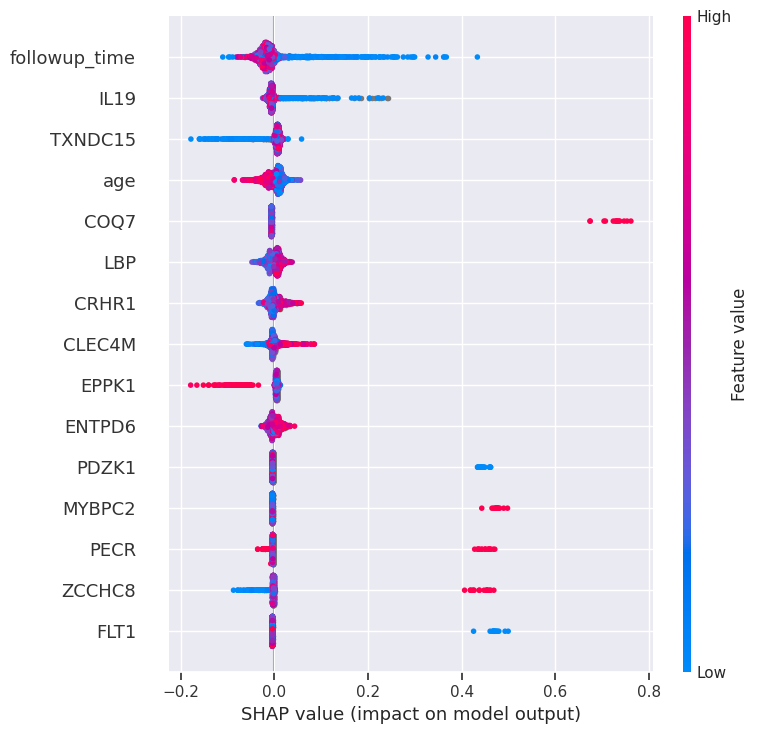

In [40]:
shap.summary_plot(shap_values_asi, x_asi.to_pandas(),
                  max_display=min(len(asi_important_feats), MAX_SHAP_FEATS))

In [41]:
x_asi, y_asi = get_xy("ASI")
best_run = wandb.Api().sweep("olink_change_asi_clf/ee09sx3s").best_run(order="acc")
model_asi = eval_xgb(x_asi, y_asi, best_run.config, is_regression=False)

wandb: Sorting runs by -summary_metrics.acc


X shape: (1868, 2930)
Prevalence=57.23%
[0]	validation_0-logloss:0.67686
[10]	validation_0-logloss:0.67506
[20]	validation_0-logloss:0.67392
[30]	validation_0-logloss:0.67247
[40]	validation_0-logloss:0.66981
[50]	validation_0-logloss:0.66830
[60]	validation_0-logloss:0.66716
[70]	validation_0-logloss:0.66606
[80]	validation_0-logloss:0.66526
[90]	validation_0-logloss:0.66457
[100]	validation_0-logloss:0.66392
[110]	validation_0-logloss:0.66162
[120]	validation_0-logloss:0.66069
[130]	validation_0-logloss:0.66063
[140]	validation_0-logloss:0.66007
[150]	validation_0-logloss:0.65945
[160]	validation_0-logloss:0.65827
[170]	validation_0-logloss:0.65726
[180]	validation_0-logloss:0.65679
[190]	validation_0-logloss:0.65702
Train (acc=0.9371, f1=0.9470)
Eval (acc=0.6390, f1=0.7523)


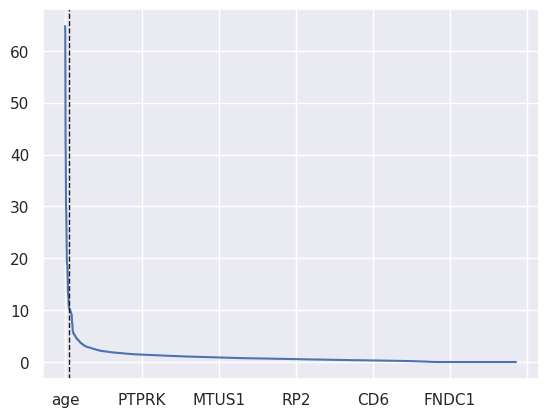

In [42]:
explainer = shap.TreeExplainer(model_asi)
shap_values_asi = explainer(x_asi)
imps = shap_to_importance(shap_values_asi, x_asi.columns)
asi_elbow = get_elbow_point(imps)
asi_important_feats = imps[:asi_elbow]

In [43]:
asi_important_feats.index.values, f"Number of important feats: {len(asi_important_feats)}"

(array(['age', 'DAPK2', 'PTN', 'WFDC2', 'TGM2', 'TXNDC15', 'MYH7B',
        'EPHB6', 'PLA2G7', 'NUDT2', 'HAGH', 'BMP6', 'SEPTIN3', 'ACVRL1',
        'FGF7', 'IL17D', 'FCGR3B', 'ENTPD6', 'ACY1', 'AGR2', 'CLEC4G',
        'TBR1', 'FCAR', 'AFM', 'ITGBL1', 'CLEC4M', 'followup_time',
        'SERPINA5'], dtype=object),
 'Number of important feats: 28')

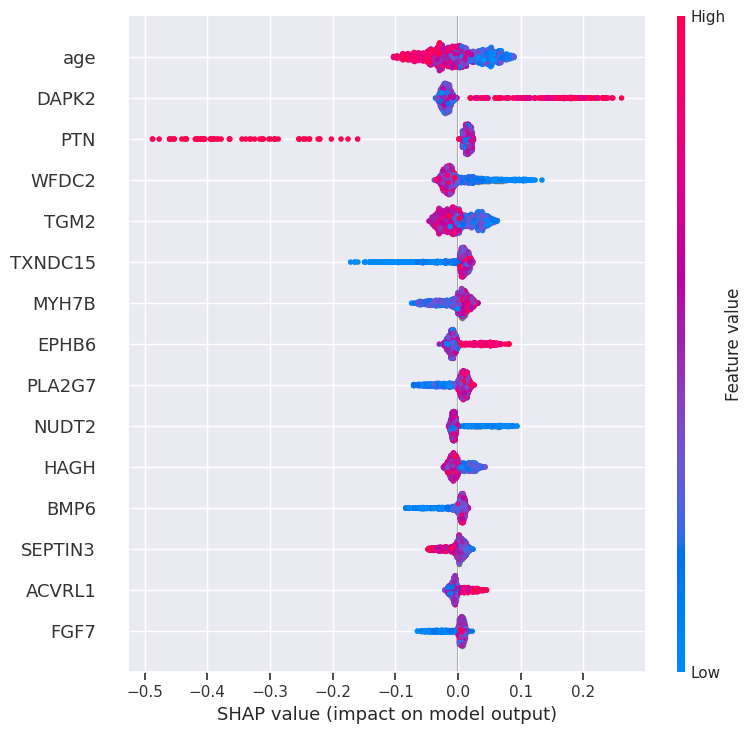

In [44]:
shap.summary_plot(shap_values_asi, x_asi.to_pandas(),
                  max_display=min(len(asi_important_feats), MAX_SHAP_FEATS))

## Wandb sweep

In [ ]:
def wandb_eval_xgb(config, x, y, seed=42, is_regression: bool = True):
    if not is_regression:
        y = y > 0
    
    X_train, X_eval, y_train, y_eval = train_test_split(x, y, test_size=TEST_SIZE,
                                                        random_state=seed)

    estimator = setup_xgb(config, seed, is_regression=is_regression)
    estimator.fit(X_train, y_train, eval_set=[(X_eval, y_eval)], verbose=0)
    return estimator.score(X_eval, y_eval)


is_reg = False
target = "SBP"
project_name = f"olink_change_{target.lower()}" + ("" if is_reg else "_clf")
x, y = get_xy(target)
objective = partial(wandb_eval_xgb, x=x, y=y, is_regression=is_reg)


def main():
    wandb.init(project=project_name)
    score = max(objective(wandb.config), -10)
    wandb.log({"r2" if is_reg else "acc": score})


sweep_configurations = {
    "method": "bayes",
    "metric": {"name": "r2" if is_reg else "acc", "goal": "maximize"},
    "parameters": {
        'n_estimators': {'distribution': 'int_uniform', 'min': 50, 'max': 500},
        'max_depth': {'distribution': 'int_uniform', 'min': 1, 'max': 10},
        'learning_rate': {'distribution': 'log_uniform_values', 'min': 0.001, 'max': 0.1},
        'subsample': {'distribution': 'uniform', 'min': 0.5, 'max': 1.0},
        'colsample_bytree': {'distribution': 'uniform', 'min': 0.5, 'max': 1.0},
        'gamma': {'distribution': 'uniform', 'min': 0, 'max': 10},
        'min_child_weight': {'distribution': 'int_uniform', 'min': 1, 'max': 20},
        'reg_alpha': {'distribution': 'log_uniform_values', 'min': 1e-5, 'max': 100},
        'reg_lambda': {'distribution': 'log_uniform_values', 'min': 1e-5, 'max': 100},
    },
}

sweep_id = wandb.sweep(sweep_configurations, project=project_name)
sweep_id

In [ ]:
wandb.teardown()
wandb.agent(sweep_id, function=main, count=200)